# Thermal system exercise session

This code lets you determine the optimal way to control a country-wide electricity system for an entire year. The code uses modesto, a toolbox for optimization of district energy systems, whch makes it very easy to set up the optimization problem for the optimal control of an electricity network.

## Imports, loading data and other stuff

In [52]:
from __future__ import division
import logging
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import modesto.utils as ut
from modesto.main import Modesto
from pkg_resources import resource_filename

In [53]:
%matplotlib notebook

In [54]:
logging.basicConfig(level=logging.ERROR,
                    format='%(asctime)s %(name)-36s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')
logger = logging.getLogger('Exercise.ipynb')

In [55]:
DATAPATH = resource_filename('modesto', 'Data')
yeardata = pd.read_excel('data/InputData.xlsx', sheet_name='YearData', header=1)
yeardata = yeardata.drop('Time', axis=1)
yeardata.index = pd.DatetimeIndex(start='20140101', periods=len(yeardata), freq='1H',name='Time')


## Setting up the electricity network

To optimize an energy network, modesto needs an object that describes the topology of the network. Here, we describe it uisng networkX, a toolbox for graph calculations.

All users and sources of electricity are connected to electricity network. The network is in this model considered as a copper plate. 
Hence, electricity network can be considered as a single point, and the actual coordinates of the different district heating components ar not important.

In [140]:
G = nx.DiGraph()

G.add_node('ElectricityNetwork', x=0, y=0, z=0,
           comps={})

# Don't connect gas boilers!
# G.add_node('CondensingGasBoilers', x=1, y=1, z=0,
#            comps={'buildings': 'BuildingFixed',
#                   'DHWtank': 'StorageVariable'})
# G.add_edge('ElectricityNetwork', 'CondensingGasBoilers', name='line1')

G.add_node('HeatPumps', x=1, y=0, z=0,
           comps={'buildings': 'BuildingFixed'})
G.add_edge('ElectricityNetwork', 'HeatPumps', name='line2')

G.add_node('FlexibleHeatPumps', x=1, y=-1, z=0,
           comps={'buildings': 'RCmodel',
                  'DHWtank': 'StorageVariable'
                 })
G.add_edge('ElectricityNetwork', 'FlexibleHeatPumps', name='line3')

G.add_node('OtherElectricityDemand', x=1, y=1, z=0,
           comps={'buildings': 'BuildingFixed'})
G.add_edge('ElectricityNetwork', 'OtherElectricityDemand', name='line4')
                  
G.add_node('SolarPanels', x=0, y=1, z=0,
           comps={'panels': 'RenewableEnergySource'})
G.add_edge('SolarPanels', 'ElectricityNetwork', name='line5')

G.add_node('OnshoreWind', x=0, y=-1, z=0,
           comps={'turbines': 'RenewableEnergySource'})
G.add_edge('ElectricityNetwork', 'OnshoreWind', name='line6')

G.add_node('OffshoreWind', x=-1, y=1, z=0,
           comps={'turbines': 'RenewableEnergySource'})
G.add_edge('ElectricityNetwork', 'OffshoreWind', name='line7')

G.add_node('CCGT', x=-1, y=0, z=0,
           comps={'plants': 'ProducerVariable'})
G.add_edge('CCGT', 'ElectricityNetwork', name='line8')

G.add_node('OCGT', x=-1, y=-1, z=0,
           comps={'plants': 'ProducerVariable'})
G.add_edge('OCGT', 'ElectricityNetwork', name='line9')

G.add_node('Import', x=2, y=1, z=0,
          comps={'plants': 'ProducerVariable'})
G.add_edge('Import', 'ElectricityNetwork', name='line10')

The resulting electricity network can be drawn:

<IPython.core.display.Javascript object>


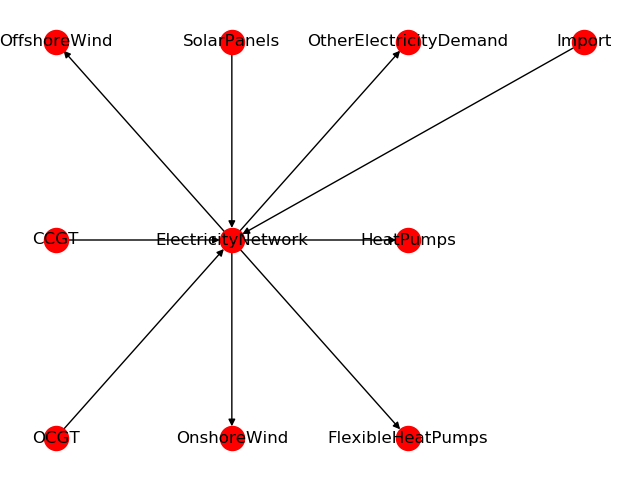

In [141]:
coordinates = {}
for node in G.nodes:
    coordinates[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

fig = plt.figure()
nx.draw(G, coordinates, with_labels=True)

## Main parameters

The electricity network will now be optimized. Depending on the capacities of the different types of heat sources and amount of 'smart' heat pumps, the behaviour of the system (CO2 emissions, curtailment, etc.) will be different.

This piece of code is the modst important part of the code! Changing these parameters will let you analyse the behaviour of the entire electricity system in different cases.

In [142]:
CapWindOn = 18900 * 10 ** 6              # Peak capacity of all onshore wind turbines [W]
CapWindOff = 8770 * 10 ** 6              # Peak capacity of all offshore wind turbines [W]
CapSol = 33700 * 10 ** 6                 # Peak capacity of all solar panels [W]
CapCCGT = 11200 * 10 ** 6               # Peak capacity of all CCGT (combined cycle gas turbine) plants [W]
CapOCGT = 5000 * 10 ** 6                # Peak capacity of all OCGT (open cycle gas turbine) [W]

CO2_price = 10 / 10 **3                 # CO2 price [euro/kg CO2]

nBuildings = 10 ** 6                    # Number of buildings that require heating
share_HP_noDR = 0.5                     # Share of buildings with a heat pump, but cannot participate in demand response
share_HP_withDR = 0.5                  # Share of buildings with a 'smart' heat pump, and can participate in demand response
share_noHP = 0.05                       # Share of buildings that have a gas boiler

# Don't change these parameters:
CapImport = 1 * 10 ** 12                 # Import capacity, don't change! [W]
import_price = 1000                      # Import price, very high, because we want to avoid using this! [euro/kWh]
fuel_price = 0.25                        # Gas price [euro/kWh]

horizon = 360*24*3600                     # 1 year is simulated, find out why 365 is not possible!
time_step = 3*3600                      # Sampling time of optimization problem is 3 hours
start_time = pd.Timestamp('20140101')   # Start time of the year that will be optimized

## Filling in model parameters

The modesto toolbox is already aware of the position and interconnections between components, nodes and edges, but still needs information rergarding, weather, prices, customer demands, component sizing, etc.

Now each of these pieces of data will be added.

We can now extract the required data from the data files we loaded in the beginning:

#### Weather data

In [143]:
t_amb = yeardata['Tamb'] + 273.15   # Ambient temperature [K]
t_g = yeardata['Tg'] + 273.15       # Ground temperature [K]
QsolN = yeardata['QsolN']           # Solar radiation, incident on surfaces facing north [W/m^2]
QsolE = yeardata['QsolE']           # Solar radiation, incident on surfaces facing east [W/m^2]
QsolS = yeardata['QsolS']           # Solar radiation, incident on surfaces facing south [W/m^2]
QsolW = yeardata['QsolW']           # Solar radiation, incident on surfaces facing west [W/m^2]

#### Building data  # TODO bathroom en floor weghalen?

In [144]:
day_max = yeardata['TmaxDZ'] + 273.15          # Maximum allowed temperatures in the day zone [K]
day_min = yeardata['TminDZ'] + 273.15          # Minimum allowed temperatures in the day zone [K]
night_max = yeardata['TmaxNZ'] + 273.15        # Maximum allowed temperatures in the night zone [K]
night_min = yeardata['TminNZ'] + 273.15        # Minimum allowed temperatures in the night zone [K]
bathroom_max = yeardata['TmaxDZ'] + 273.15     # Maximum allowed temperatures in the bathroom zone [K]
bathroom_min = yeardata['TminDZ'] + 273.15     # Minimum allowed temperatures in the bathroom zone [K]
floor_max = yeardata['TmaxDZ'] + 273.15        # Maximum allowed temperatures of the floor [K]
floor_min = yeardata['TminDZ'] + 273.15        # Minimum allowed temperatures of the floor [K]
Q_int_D = yeardata['QintD']                    # Internal heat gains in the day zone [W]
Q_int_N = yeardata['QintN']                    # Internal heat gains in the night zone [W]
mf_DHW = yeardata['mDHW']                      # DHW use [kg/s]

day_max[pd.Timestamp('20140601'):pd.Timestamp('20140921')] = 50 + 273.15
night_max[pd.Timestamp('20140601'):pd.Timestamp('20140921')] = 50 + 273.15

#### Producer data

In [145]:
c_fuel = pd.Series(fuel_price, index=t_amb.index) # Fuel price throughout the year, is assumed constant [euro]
c_O2 = pd.Series(CO2_price, index=t_amb.index) # CO2 price throughout the year. Is assumed constant! [euro/kg CO2]
c_import = pd.Series(import_price, index=t_amb.index) # import price throughout the year. Is assumed constant! [euro/kWh]

### Setting modesto parameters

In order to solve the problem, all parameters of the optimization problem are assigned the collected values. 

In [146]:
general_params = \
    {
        'Te': yeardata['Tamb'] + 273.15,          # Ambient temperature [K]
        'Tg': yeardata['Tg'] + 273.15,            # Ground temperature [K]
        'Q_sol_E': QsolE,                         # Solar radiation, incident on surfaces facing east [W/m^2]
        'Q_sol_W': QsolW,                         # Solar radiation, incident on surfaces facing west [W/m^2]
        'Q_sol_S': QsolS,                         # Solar radiation, incident on surfaces facing north [W/m^2]
        'Q_sol_N': QsolN,                         # Solar radiation, incident on surfaces facing south [W/m^2],
        'horizon': horizon,
        'time_step': time_step
    }

non_flexible_heat_pumps = \
    {
        'delta_T': 20,                           # TODO remove this parameter, only useful in case of district heating
        'mult': nBuildings * share_HP_noDR,      # Number of buildings of this type
        'heat_profile': yeardata['Ptot1house'],  # Electricity use of an average building's heat pump throughout the year [W]
        'COP': 3                                 # Heat pump COP [-]
    }
    
other_electricity_demand = \
{
    'delta_T': 20,                                  # TODO remove this parameter, only useful in case of district heating
    'mult': 1,                                      # Number of buildings of this type
    'heat_profile': yeardata['dem_fix'] * 10 ** 6,  # Electricity use of an average building's heat pump throughout the year [W]
    'COP': 1                                        # Heat pump COP [-]
}


flexible_heat_pumps_buildings = \
    {
        'delta_T': 20,                            # TODO remove this parameter, only useful in case of district heating
        'mult': nBuildings * share_HP_withDR,     # Number of buildings of this type
        'night_min_temperature': night_min,       # Minimum allowed temperatures in the night zone [K]
        'night_max_temperature': night_max,       # Maximum allowed temperatures in the night zone [K]
        'day_min_temperature': day_min,           # Minimum allowed temperatures in the day zone [K]
        'day_max_temperature': day_max,           # Maximum allowed temperatures in the day zone [K]
        'bathroom_min_temperature': bathroom_min, # Minimum allowed temperatures in the bathroom zone [K]
        'bathroom_max_temperature': bathroom_max, # Maximum allowed temperatures in the bathroom zone [K]
        'floor_min_temperature': floor_min,       # Maximum allowed temperatures of the floor [K]
        'floor_max_temperature': floor_max,       # Minimum allowed temperatures of the floor [K]
        'model_type': 'SFH_T_5_ins_TAB',          # Name of the model type, indicating insulation standards of the building
        'Q_int_D': Q_int_D,                       # Internal heat gains in the day zone [W]
        'Q_int_N': Q_int_N,                       # Internal heat gains in the night zone [W]
        'TiD0': 18 + 273.15,                      # Initial temperature of the air in the day zone [K]
        'TflD0': 18 + 273.15,                     # Initial temperature of the floor in the day zone [K]
        'TwiD0': 18 + 273.15,                     # Initial temperature of the window in the day zone [K]
        'TwD0': 18 + 273.15,                      # Initial temperature of the wall in the day zone [K]
        'TfiD0': 18 + 273.15,                     # Initial temperature of the floor between day and night zone (day side) [K]
        'TfiN0': 18 + 273.15,                     # Initial temperature of the floor between day and night zone (night side) [K]
        'TiN0': 18 + 273.15,                      # Initial temperature of the air in the night zone [K]
        'TwiN0': 18 + 273.15,                     # Initial temperature of the window in the night zone [K]
        'TwN0': 18 + 273.15,                      # Initial temperature of the wall in the night zone [K]
        'max_heat': 20000,                        # Maximum heat that can be delivered to the building # TODO aanpassen naar elektriciteitsnetwerk
        'COP': 3                                  # Heat pump COP [-]
    }

flexible_heat_pumps_dhw = \
    {
        'Thi': 60 + 273.15,                                     # Warm temperature of the stratified storage tank [K]
        'Tlo': 10 + 273.15,                                     # Low temperature of the stratified storage tank [K]
        'mflo_max': 0.05,                                       # Maximum mass flow rate to the tank [kg/s]
        'mflo_min': 0,                                          # Minimum mass flow rate to the tank [kg/s]
        'volume': 0.25,                                         # Volume of one tank [m^3]
        'ar': 2,                                                # Area ratio of the tank (TODO definitie opzoeken)
        'dIns': 0.1,                                            # Thickness of the insulation (TODO Goede waarde opzoeken)
        'kIns': 0.024,                                          # Heat conduction coefficient [W/m/K]
        'heat_stor': 0,                                         # Initial amount of heat stored in the tank [J] TODO juiste eenheid?
        'mflo_use': mf_DHW,                                     # Domestic hot water that is used by the residents [kg/s]
        'COP': 3,                                               # Heat pump COP [-]m
        'mult': nBuildings * share_HP_withDR
    }

ccgt = \
    {
        'efficiency': 0.6,    # Efficiency of the plant [-] 
        'PEF': 2,             # Primary energy factor (not used in this case)
        'CO2': 0.2052,        # Specific CO2 emission, based on HHV of CH4 [kg/KWh thermal]
        'fuel_cost': c_O2,    # Fuel cost, # TODO in this case CO2 price 
        'Qmax': CapCCGT,      # Maximum power output [W]
        'ramp_cost': 0.01,    # Cost to ramp (increase or decrease power) euro/kW # TODO eenheid
        'ramp': CapCCGT       # Maximum ramp in one time step
    }

ocgt = \
    {
        'efficiency': 0.4,    # Efficiency of the plant [-] 
        'PEF': 2,             # Primary energy factor (not used in this case)
        'CO2': 0.2052,         # Specific CO2 emission, based on HHV of CH4 [kg/KWh CH4]
        'fuel_cost': c_O2,    # fuel cost, # TODO in this case CO2 price 
        'Qmax': CapOCGT,      # Maximum power output [W]
        'ramp_cost': 0.01,    # Cost to ramp (increase or decrease power) euro/kW # TODO eenheid
        'ramp': CapOCGT       # Maximum ramp in one time step
    }
    
import_plants = \
    { # Assumed to be a perfect plant
        'efficiency': 1,      # Efficiency of the plant [-] 
        'PEF': 2,             # Primary energy factor (not used in this case)
        'CO2': 0.2052,         # Specific CO2 emission, based on HHV of CH4 [kg/KWh CH4]
        'fuel_cost': c_import,# Fuel cost, # TODO in this case import price
        'Qmax': CapImport,    # Maximum power output [W]
        'ramp_cost': 0,       # Cost to ramp (increase or decrease power) euro/kW # TODO eenheid
        'ramp': CapImport     # Maximum ramp in one time step
    }

onshore_wind_turbines = \
    {
        'delta_T': 20,                                      # Temperature difference across substation TODO not needed now [K]
        'heat_profile': yeardata['g_wind_on'] * CapWindOn   # Renewable generation profile [W]
    }
    
offshore_wind_turbines = \
    {
        'delta_T': 20,                                       # Temperature difference across substation TODO not needed now [K]
        'heat_profile': yeardata['g_wind_off'] * CapWindOff  # Renewable generation profile [W]
    }
    
solar_panels = \
    {
        'delta_T': 20,                                       # Temperature difference across substation TODO not needed now [K]
        'heat_profile': yeardata['g_solar'] * CapSol         # Renewable generation profile [W]
    }


## Setting up modesto

These are the main parameters hat are needed to start up the modesto toolbox and to optimize the control of the electricity system:
* **Horizon** of the optimization problem (in seconds)
* **Time step** of the (discrete) problem (in seconds)
* **Start time** (should be a pandas TimeStamp).
* **Pipe model**: The type of model used to model the electricity network. 
* **Graph**: Object describing the energy system topology

In [147]:
pipe_model = 'SimplePipe'               # Type of model that is used to model the electrciity network, TODO change model name!!

optmodel = Modesto(pipe_model=pipe_model, 
                   graph=G)

OnshoreWind.turbines
OffshoreWind.turbines
HeatPumps.buildings
SolarPanels.panels
OtherElectricityDemand.buildings
OCGT.plants
Import.plants
CCGT.plants
FlexibleHeatPumps.DHWtank
FlexibleHeatPumps.buildings


In [148]:
optmodel.change_params(general_params)

optmodel.change_params(non_flexible_heat_pumps, 
                       node='HeatPumps',
                       comp='buildings')

optmodel.change_params(other_electricity_demand, 
                       node='OtherElectricityDemand',
                       comp='buildings')

optmodel.change_params(flexible_heat_pumps_buildings, 
                       node='FlexibleHeatPumps',
                       comp='buildings')

optmodel.change_params(flexible_heat_pumps_dhw, 
                       node='FlexibleHeatPumps',
                       comp='DHWtank')

optmodel.change_params(ccgt, 
                       node='CCGT', 
                       comp='plants')

optmodel.change_params(ocgt, 
                       node='OCGT', 
                       comp='plants')

optmodel.change_params(import_plants, 
                       node='Import', 
                       comp='plants')

optmodel.change_params(onshore_wind_turbines, 
                       node='OnshoreWind', 
                       comp='turbines')

optmodel.change_params(offshore_wind_turbines, 
                       node='OffshoreWind', 
                       comp='turbines')

optmodel.change_params(solar_panels, 
                       node='SolarPanels', 
                       comp='panels')

## Solving the optimization problem

modesto now has all required data and can compile and solve the problem. 

In [ ]:
optmodel.compile(start_time=start_time)

In [ ]:
optmodel.set_objective('cost_fuel_co2')    # Optimize the control such that the operating costs are minimal

Finally, the problem can be solved:

In [ ]:
optmodel.solve(tee=True, solver='gurobi', lpmethod=4)

## Collecting results

### The objective(s)

The get_objective_function gets the value of the active objective (if no input) or of a specific objective if an extra input is given (not necessarily active, hence not an optimal value).

In [132]:
print '\nSlack: ', optmodel.model.Slack.value
print 'Active:', optmodel.get_objective()
print 'Energy:', (optmodel.get_objective('energy') - optmodel.model.Slack.value)/10**6, ' GWh'
print 'Cost:  ', (optmodel.get_objective('cost_fuel_co2') - optmodel.model.Slack.value)/10**6, ' million euro'


Slack:  2165997.11374
Active: 343582017.142
Energy: 68283.2040056  GWh
Cost:   341.416020028  million euro


modesto has the get_result method, whch allows to get the optimal values of the optimization variables:

### Buildings

Collecting the data for the Building.building component:

In [133]:
TiD = optmodel.get_result('StateTemperatures', node='FlexibleHeatPumps',
                           comp='buildings', index='TiD', state=True)
TiN = optmodel.get_result('StateTemperatures', node='FlexibleHeatPumps',
                           comp='buildings', index='TiN', state=True)
Q_hea_D = optmodel.get_result('ControlHeatFlows', node='FlexibleHeatPumps',
                                comp='buildings', index='Q_hea_D')
Q_hea_N = optmodel.get_result('ControlHeatFlows', node='FlexibleHeatPumps',
                                comp='buildings', index='Q_hea_N')

Creating plots:

<IPython.core.display.Javascript object>


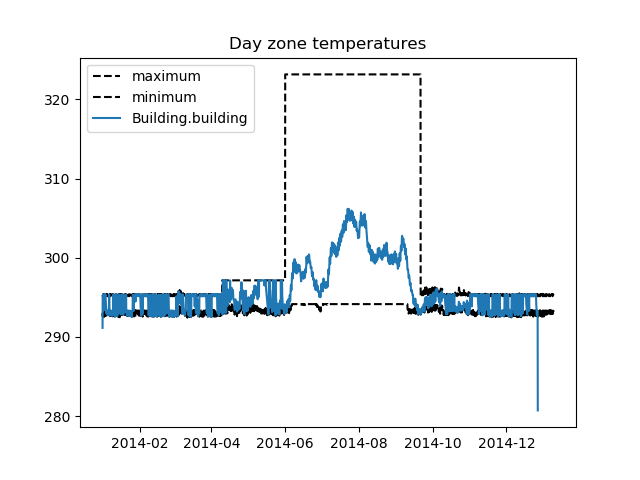

<IPython.core.display.Javascript object>


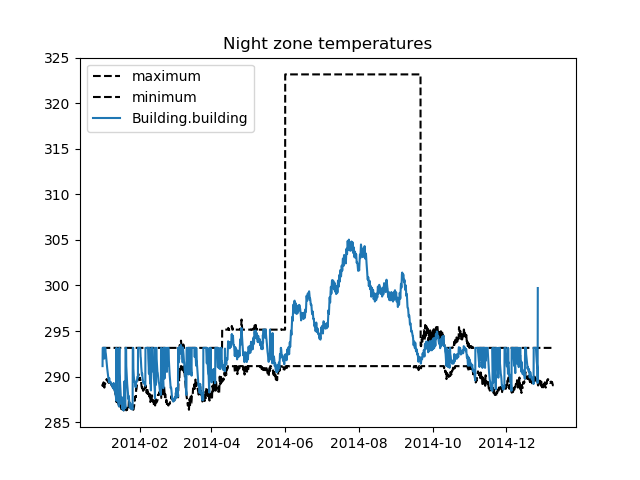

<IPython.core.display.Javascript object>


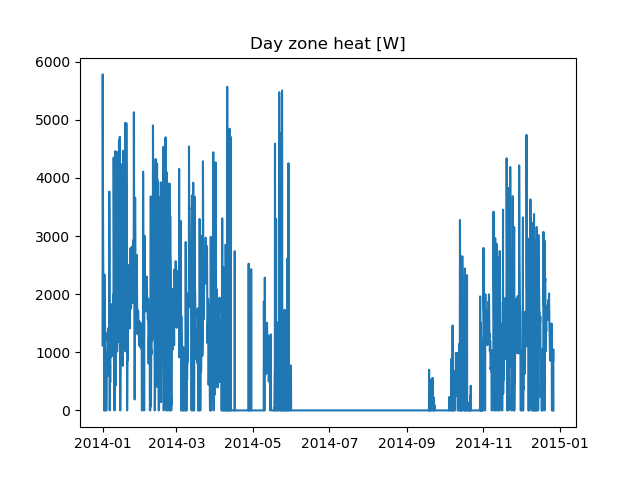

<IPython.core.display.Javascript object>


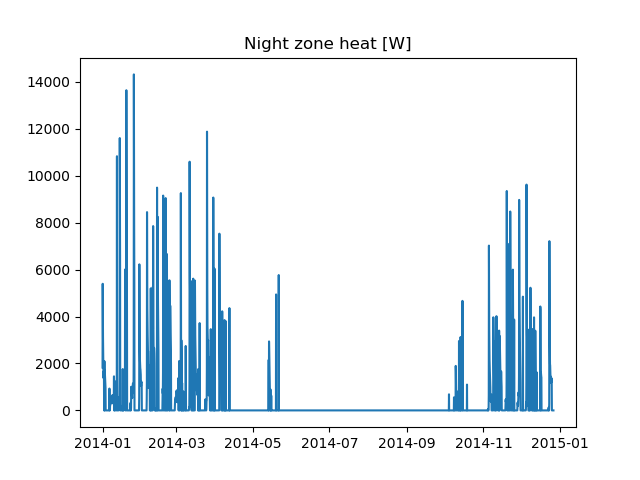

Text(0.5,1,u'Night zone heat [W]')

In [139]:
userprofile = ut.read_period_data(path=DATAPATH, name='UserBehaviour/ISO13790.csv',
                                time_step=time_step, horizon=horizon, start_time=start_time)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# ax1 = fig1.add_subplot(221)
ax1.plot(day_max, label='maximum', linestyle='--', color='k')
ax1.plot(day_min, label='minimum', linestyle='--', color='k')
ax1.plot(TiD, label='Building.building')
ax1.legend()
ax1.set_title('Day zone temperatures')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(night_max, label='maximum', linestyle='--', color='k')
ax2.plot(night_min, label='minimum', linestyle='--', color='k')
ax2.plot(TiN, label='Building.building')
ax2.legend()
ax2.set_title('Night zone temperatures')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(Q_hea_D)
ax3.set_title('Day zone heat [W]')

fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(Q_hea_N)
ax4.set_title('Night zone heat [W]')



## Storage unit

In [135]:
storage_stored_heat = optmodel.get_result('heat_stor', node='FlexibleHeatPumps',
                                  comp='DHWtank')
storage_heat_flow = optmodel.get_result('heat_flow', node='FlexibleHeatPumps',
                                 comp='DHWtank')

KeyError: 'There is no component named FlexibleHeatPumps.DHWtank at node FlexibleHeatPumps'

In [ ]:
fig1, (ax, ax2) = plt.subplots(2,1, sharex=True)
ax.plot(storage_stored_heat)
ax.set_title('Stored heat [kWh]')
ax2.plot(storage_heat_flow)
ax2.set_title('Heat flow to the tank [W]')
ax2.axhline(linestyle='--', color='g')

## Heat generation unit

In [136]:
CCGT_e = optmodel.get_result('heat_flow', node='CCGT', comp='plants') / 10 ** 9
OCGT_e = optmodel.get_result('heat_flow', node='OCGT', comp='plants') / 10 **9

onshoreWind_e_max = yeardata['g_wind_on'] * CapWindOn / 10 **9
onshoreWind_e_curt = optmodel.get_result('heat_flow', node='OnshoreWind', comp='turbines') / 10 **9
offshoreWind_e_max =yeardata['g_wind_off'] * CapWindOff / 10 **9
offshoreWind_e_curt = optmodel.get_result('heat_flow', node='OffshoreWind', comp='turbines') / 10 **9
solar_e_curt = optmodel.get_result('heat_flow', node='SolarPanels', comp='panels') / 10 **9
solar_e_max = yeardata['g_solar'] * CapSol / 10 **9

curtailed_e = ut.resample(onshoreWind_e_max, time_step)[pd.Timestamp('20140101'):pd.Timestamp('20150101')] - onshoreWind_e_curt \
            + ut.resample(offshoreWind_e_max, time_step)[pd.Timestamp('20140101'):pd.Timestamp('20150101')] - offshoreWind_e_curt \
            + ut.resample(solar_e_curt, time_step)[pd.Timestamp('20140101'):pd.Timestamp('20150101')] - solar_e_curt
res_e = onshoreWind_e_max[pd.Timestamp('20140101'):pd.Timestamp('20150101')] + \
        offshoreWind_e_max[pd.Timestamp('20140101'):pd.Timestamp('20150101')] + \
        solar_e_max[pd.Timestamp('20140101'):pd.Timestamp('20150101')]

curtailed_e = curtailed_e.fillna(0)

import_e = optmodel.get_result('heat_flow', node='Import', comp='plants') / 10 **9

total_e = import_e + CCGT_e + OCGT_e + onshoreWind_e_curt + offshoreWind_e_curt + solar_e_curt

<IPython.core.display.Javascript object>


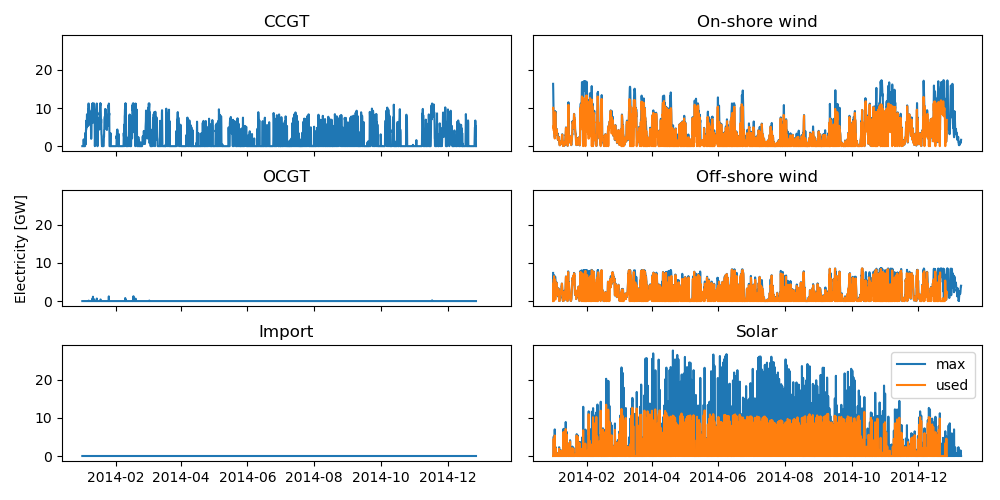

In [137]:
fig, axarr = plt.subplots(3, 2 , sharex=True, sharey=True, figsize=(10,5))

axarr[0,0].plot(CCGT_e)
axarr[0,0].set_title('CCGT')

axarr[1,0].plot(OCGT_e)
axarr[1,0].set_title('OCGT')
axarr[1,0].set_ylabel('Electricity [GW]')

axarr[2,0].plot(import_e)
axarr[2,0].set_title('Import')

axarr[0,1].plot(onshoreWind_e_max, label='max')
axarr[0,1].plot(onshoreWind_e_curt, label='used')
axarr[0,1].set_title('On-shore wind')

axarr[1,1].plot(offshoreWind_e_max, label='max')
axarr[1,1].plot(offshoreWind_e_curt, label='used')
axarr[1,1].set_title('Off-shore wind')

axarr[2,1].plot(solar_e_max, label='max')
axarr[2,1].plot(solar_e_curt, label='used')
axarr[2,1].legend()
axarr[2,1].set_title('Solar')
fig.tight_layout()

In [ ]:
fig2, ax6 = plt.subplots(1, 1, figsize=(7,5))
ax6.plot(total_e)

In [138]:
print sum(import_e)/sum(total_e) *100, ' % of total energy demand had to be imported'
print sum(curtailed_e)/sum(res_e)*100, ' % of total RES had to be curtailed'

0.0  % of total energy demand had to be imported
7.45646171678  % of total RES had to be curtailed
